In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pickle as pkl
sys.path.append('/home/jungyoung/Project/hh_neuralnet/include/')
import hhtools
import hhsignal
import importlib
from tqdm.notebook import tqdm, trange
# other options
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.facecolor'] = 'w'
np.set_printoptions(suppress=True)
from importlib import reload

import oscdetector as od
import hhinfo

In [3]:
summary_obj = hhtools.SummaryLoader("../gen_three_pop_samples_repr/data")

srate = 2000

key_names = ("fpop", "spop")
amp_range_set = [
    dict(fpop=[[]], spop=[[]]), # 1
    dict(fpop=[[]], spop=[[]]), # 2
    dict(fpop=[[20, 30], [40, 50]],
         spop=[[20, 30]]), # 3
    dict(fpop=[[30, 40], [50, 70]],
         spop=[[30, 40]]), # 4
    dict(fpop=[[], [60, 70]],
         spop=[[25, 35], [60, 70]]), # 5 -> tuned
    dict(fpop=[[50, 70]], 
         spop=[[20, 40], [50, 70]]), # 6
    dict(fpop=[[60, 70]],
         spop=[[60, 70]]), # 7
    dict(fpop=[[30, 40], [60, 70]],
         spop=[[30, 40]]), # 8 -> tuned
]

# frequency range are determined based on fourier transform result

Load cache file


In [4]:
with open("./data/te_tmp_5.pkl", "rb") as fp:
    te_data5 = pkl.load(fp)
    
with open("./data/te_tmp_8.pkl", "rb") as fp:
    te_data8 = pkl.load(fp)

In [5]:
tlag_max = 15
srate_d = 2000

nlag_max = int(tlag_max * 1e-3 * srate_d)
te_motif5, len_motif5 = te_data5["te"], te_data5["len"]
te_motif8, len_motif8 = te_data8["te"], te_data8["len"]

In [76]:
h_norm = []
h_std = []
# h_norm = np.zeros([2, 16, 2])
for h in [te_data5["h"], te_data8["h"]]:
    h_norm.append(np.zeros((16, 2)))
    h_std.append(np.zeros((16, 2)))
    for i in range(16):
        if len(h[i]) == 0:
            h_norm[-1][i] = [np.nan, np.nan]
            h_std[-1][i] = [np.nan, np.nan]
            continue
        h_norm[-1][i] = np.average(h[i], axis=0)
        h_std[-1][i] = np.std(h[i], axis=0)

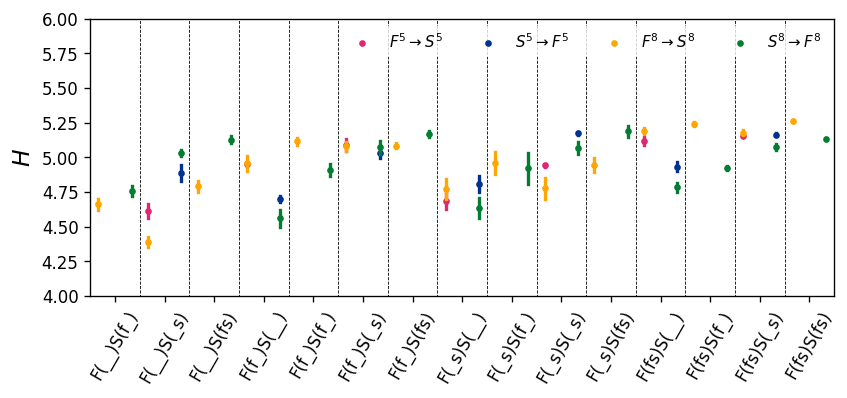

In [96]:
cs = [["#e02771", "#003391"], ["#ffa600", "#027d31"]]
    
labels = [r"$F^5 \rightarrow S^5$", r"$S^5 \rightarrow F^5$", r"$F^8 \rightarrow S^8$", r"$S^8 \rightarrow F^8$"]

plt.figure(figsize=(8, 3))
line_obj = [[] for _ in range(4)]
# for n in range(2):
for n, te in enumerate([te_data5, te_data8]):
    for i in range(16):
        if np.isnan(h_norm[n][i][0]): continue

        h = h_norm[n][i]
        hs = h_std[n][i]
        num = len(te["h"][i])

        for j in range(2):
            x = i + (-1)**(j+1)/3
            m, s = h[j], hs[j]/np.sqrt(num) * 1.96
            
            # m = te[j,nmax]
            line_obj[2*n+j], = plt.plot(x, m, '.', c=cs[n][j])
            # s = te_motif[i][:,j,nmax].std() * 1.96/np.sqrt(te_motif[i].shape[0])/2
            # c = 
            plt.plot([x, x], [m-s, m+s], c=cs[n][j], lw=2)
    

# for n, te_motif in enumerate([te_motif5, te_motif8]):
#     # plt.subplot(2,1,n+1)
#     for i in range(16):
#         if len(te_motif[i]) == 0: continue
#         # te = np.average(te_motif[i], axis=0)/ np.max(h_norm[n][i])
#         h = h_norm[i]
        
#         for j in range(2):
#             nmax = np.argmax(te[j])
#             if i == 0:
#                 plt.plot([0, 16], [te[j, nmax], te[j,nmax]], '--', c=cs[n][j], zorder=-1, lw=0.5)
#             else:
#                 x = i + (-1)**(j+1)/3
#                 m = te[j,nmax]
#                 line_obj[2*n+j], = plt.plot(x, m, '.', c=cs[n][j])
#                 s = te_motif[i][:,j,nmax].std() * 1.96/np.sqrt(te_motif[i].shape[0])/2
#                 # c = 
#                 plt.plot([x, x], [m-s, m+s], c=cs[n][j], lw=2)
    
for i in range(16):            
    # plt.vlines(i-0.3, 0, 2, color='k', linestyles='--', lw=1)
    plt.vlines(i+0.5, 3, 7, color='k', linestyles='--', lw=0.5, zorder=-1)
        
plt.legend(line_obj, labels, ncol=4, loc="upper right", fontsize=9, edgecolor="none")
plt.xticks(np.arange(1, 16), labels=od.get_motif_labels()[1:], rotation=60)
plt.xlim([0.5, 15.5])
plt.ylim([4, 6])
plt.ylabel(r"$H$", fontsize=14)
plt.show()

# plt.plot(tlag_max, '.-')

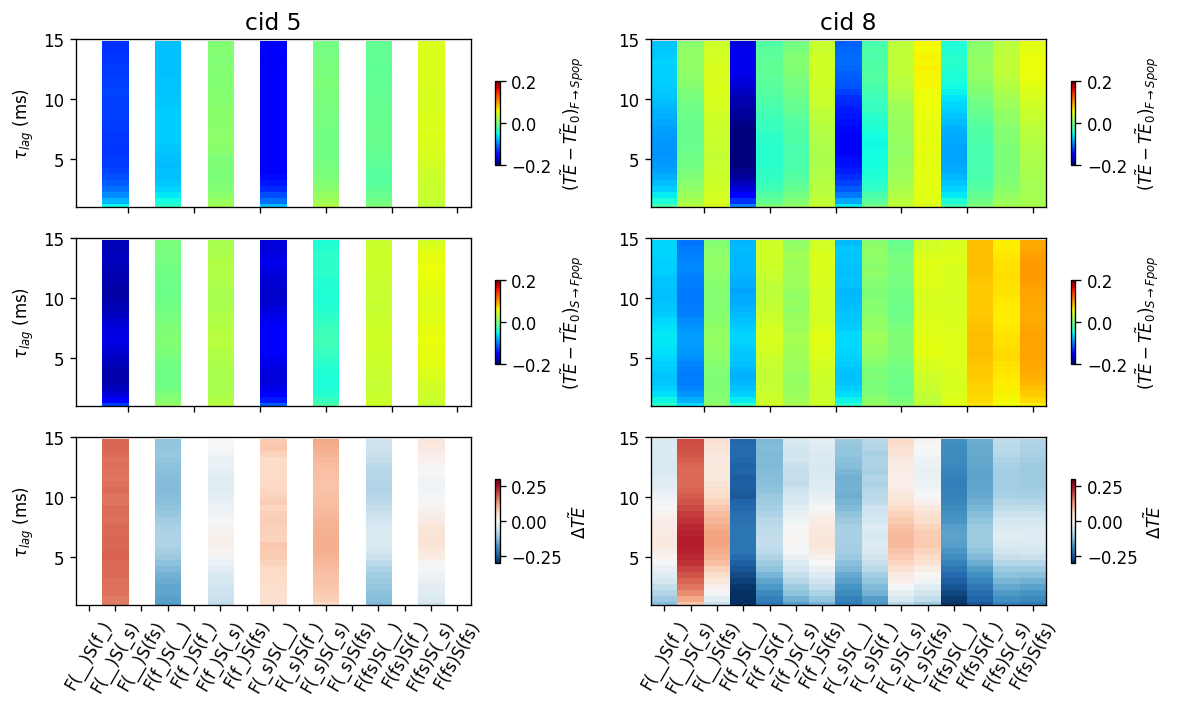

In [69]:
labels = (
    r"$(\tilde{TE}-\tilde{TE}_0)_{F\rightarrow S pop}$",
    r"$(\tilde{TE}-\tilde{TE}_0)_{S\rightarrow F pop}$",
    r"$\Delta \tilde{TE}$"
)

num_motif = 16
x = np.arange(num_motif)
y = np.arange(nlag_max) / srate_d * 1e3

fig, axs = plt.subplots(3, 2, figsize=(10, 6))
for n , te_motif in enumerate([te_motif5, te_motif8]):
    # compute averaged TE
    im_te = np.zeros((16, 2, nlag_max)) * np.nan
    for i in range(num_motif):
        if len(te_motif[i]) == 0: continue

        h = h_norm[n][i]
        im_te[i] = np.average(te_motif[i], axis=0) / h[:, None]

    # swap axes
    im_te = np.swapaxes(im_te, 0, 1)

    # compute TE difference
    norm = np.max(im_te, axis=0)
    norm[norm == 0] = np.inf
    diff_te = (im_te[0] - im_te[1]) / norm # +: F->S, -: S->F

    # subtract baseline TE
    im_te = im_te - im_te[:,0,None,:]

    # draw TE
    for i in range(3):
        plt.axes(axs[i][n])
        if i == 2: # draw difference
            hhtools.imshow_xy(diff_te.T, x=x, y=y, cmap='RdBu_r', vmin=-0.3, vmax=0.3)
        else:
            hhtools.imshow_xy(im_te[i].T, x=x, y=y, cmap='jet', vmin=-0.2, vmax=0.2)
            
        plt.colorbar(shrink=0.5, label=labels[i])
    
for n in range(3):
    axs[n][0].set_ylabel(r"$\tau_{lag}$ (ms)")
    for i in range(2):
        if n < 2:
            axs[n][i].set_xticklabels([])
        else:
            axs[n][i].set_xticks(np.arange(16))
            axs[n][i].set_xticklabels(od.get_motif_labels(), rotation=60)
            
        axs[n][i].set_ylim([1, 15])
        axs[n][i].set_xlim([0.5, 15.5])

axs[0][0].set_title("cid 5", fontsize=14)
axs[0][1].set_title("cid 8", fontsize=14)
# axs[0][2].set_xticks

plt.tight_layout()
plt.show()


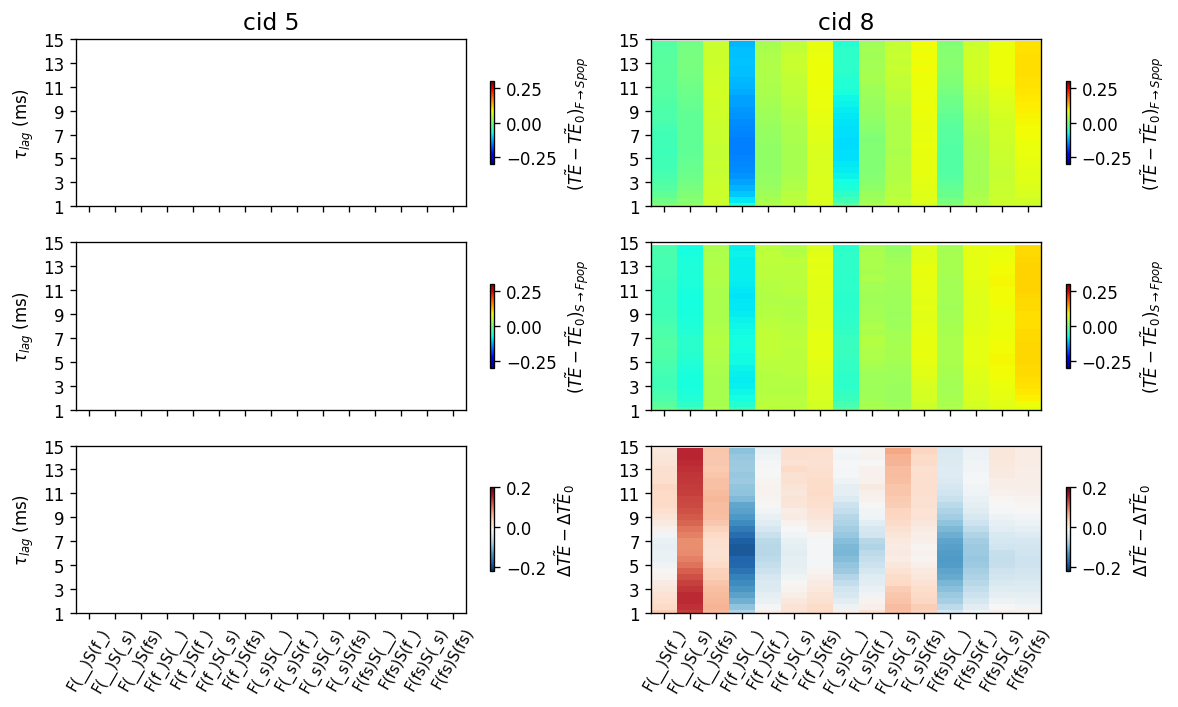

In [7]:
labels = (
    r"$(\tilde{TE}-\tilde{TE}_0)_{F\rightarrow S pop}$",
    r"$(\tilde{TE}-\tilde{TE}_0)_{S\rightarrow F pop}$"
    # r"$\tilde{TE}_{S\rightarrow F pop}$"
)

x = np.arange(16)
y = np.arange(nlag_max) / srate_d * 1e3


fig, axs = plt.subplots(3, 2, figsize=(10, 6))
for n , te_motif in enumerate([te_motif5, te_motif8]):
    # generate average image
    im_te = np.zeros((2, nlag_max, 16)) * np.nan

    im_te_base = np.average(te_motif[0], axis=0) / np.max(h_norm[n][i])
    d_im_te_base = (im_te_base[0] - im_te_base[1]) / (np.max(im_te_base, axis=0)+1e-13)
    
    for i in range(1, 16):
        if len(te_motif[i]) == 0: continue
        im_te[:, :, i] = np.average(te_motif[i], axis=0) / np.max(h_norm[n][i])
        
    im_dte = (im_te[0] - im_te[1]) / (np.max(im_te, axis=0)+1e-13) # +: F->S, -: S->F
    
    for i in range(3):
        plt.axes(axs[i][n])
        if i != 2:
            im = im_te[i] - im_te_base[i][:, None]
            hhtools.imshow_xy(im[1:,:], x=x, y=y[1:], cmap='jet', vmin=-0.3, vmax=0.3)
            # hhtools.imshow_xy(im_te[i][1:, :], x=x, y=y[1:], cmap='jet', vmin=0, vmax=0.5)
        else:
            im = im_dte - d_im_te_base[:, None]
            hhtools.imshow_xy(im[1:,:], x=x, y=y[1:], cmap='RdBu_r', vmax=-0.2, vmin=0.2)
            # hhtools.imshow_xy(im_dte[1:, :], x=x, y=y[1:], cmap='RdBu_r', vmax=-0.2, vmin=0.2)
        plt.yticks(x[1::2])
        plt.ylim([1, 15])
        plt.xticks(np.arange(16), labels=[])
        # plt.xlim([, 15.5])
        # plt.xticks(np.arange(116), labels=[])
        if i != 2:
            plt.colorbar(shrink=0.5, label=labels[i])
        else:
            plt.xticks(np.arange(16), labels=od.get_motif_labels(), rotation=60, fontsize=9)
            plt.colorbar(shrink=0.5, label=r"$\Delta \tilde{TE}-\Delta \tilde{TE}_0$")
        plt.xlim([0.5, 15.5])
        # plt.xlim([-.5, 15.5])

for n in range(3):
    axs[n][0].set_ylabel(r"$\tau_{lag}$ (ms)")

axs[0][0].set_title("cid 5", fontsize=14)
axs[0][1].set_title("cid 8", fontsize=14)

plt.tight_layout()
plt.show()

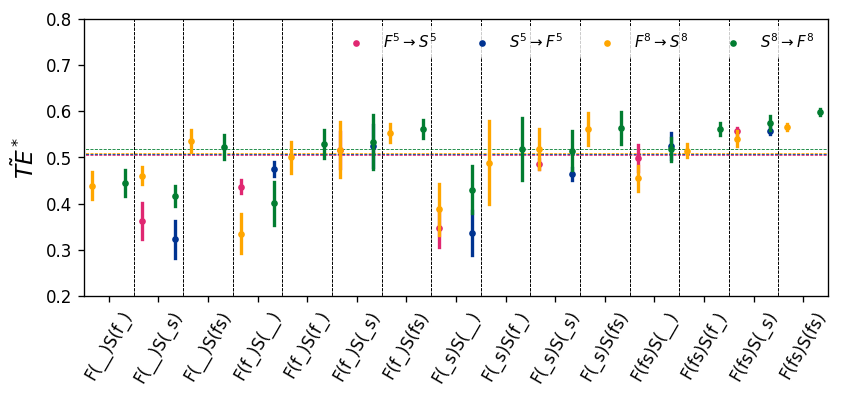

In [15]:
cs = [["#e02771", "#003391"], ["#ffa600", "#027d31"]]
    
labels = [r"$F^5 \rightarrow S^5$", r"$S^5 \rightarrow F^5$", r"$F^8 \rightarrow S^8$", r"$S^8 \rightarrow F^8$"]

plt.figure(figsize=(8, 3))
line_obj = [[] for _ in range(4)]
for n, te_motif in enumerate([te_motif5, te_motif8]):
    # plt.subplot(2,1,n+1)
    for i in range(16):
        if len(te_motif[i]) == 0: continue
        te = np.average(te_motif[i], axis=0)/ np.max(h_norm[n][i])
        
        for j in range(2):
            nmax = np.argmax(te[j])
            if i == 0:
                plt.plot([0, 16], [te[j, nmax], te[j,nmax]], '--', c=cs[n][j], zorder=-1, lw=0.5)
            else:
                x = i + (-1)**(j+1)/3
                m = te[j,nmax]
                line_obj[2*n+j], = plt.plot(x, m, '.', c=cs[n][j])
                s = te_motif[i][:,j,nmax].std() * 1.96/np.sqrt(te_motif[i].shape[0])/2
                # c = 
                plt.plot([x, x], [m-s, m+s], c=cs[n][j], lw=2)
    
    for i in range(16):            
        # plt.vlines(i-0.3, 0, 2, color='k', linestyles='--', lw=1)
        plt.vlines(i+0.5, 0, 2, color='k', linestyles='--', lw=0.5, zorder=-1)
        
plt.legend(line_obj, labels, ncol=4, loc="upper right", fontsize=9, edgecolor="none")
plt.xticks(np.arange(1, 16), labels=od.get_motif_labels()[1:], rotation=60)
plt.xlim([0.5, 15.5])
plt.ylim([0.2, 0.8])
plt.ylabel(r"$\tilde{TE}^*$", fontsize=14)
# plt.yticks(np.arange(0, 2.1, 0.5))
plt.show()

# plt.plot(tlag_max, '.-')

In [84]:
cs = [["#e02771", "#003391"], ["#ffa600", "#027d31"]]

tlag_cat = np.arange(-29, 30) / srate_d * 1e3

plt.figure(figsize=(8, 3))
line_obj = [[] for _ in range(4)]
for n, te_motif in enumerate([te_motif5, te_motif8]):

    # tlag_max = np.zeros(16) * np.nan

    te_b = np.average(te_motif[0], axis=0) / np.max(h_norm[n][0])
    for i in range(1, 16):
        if len(te_motif[i]) == 0: continue
        te = np.average(te_motif[i], axis=0)/ np.max(h_norm[n][i]) - te_b
        dte = te[0] - te[1] # F->S, S->F

        dte_max = np.max(dte)
        dte_min = np.min(dte)

        if dte_max < 0:
            nmax = np.argmax(dte_max)
        elif dte_max > 0:
            nmax = np.argmin(dte_min)

        
        
        

#         te_cat = np.concatenate((te[0], te[1][1:])) # F->S, S->F
#         tlag_max[i] = tlag_cat[np.argmax(te_cat)]

#     plt.plot(tlag_max, '.', c=cs[n][0])
        
# plt.xticks(np.arange(1, 16), labels=od.get_motif_labels()[1:], rotation=60)
# plt.show()

<Figure size 960x360 with 0 Axes>

In [266]:
cid = 5
amp_range = amp_range_set[cid-1]

nlag_max = int(tlag_max * 1e-3 * srate_d)
py = np.zeros((16, nbin))
pyx = np.zeros((16, nbin, nbin))
pyy = np.zeros((16, nbin, nbin, nlag_max))
pyyx = np.zeros((16, nbin, nbin, nbin, nlag_max))

word_count = np.zeros(16)
for i in trange(200):
    detail_data = summary_obj.load_detail(cid-1, i)
    psd_set, fpsd, tpsd = od.compute_stfft_all(detail_data, mbin_t=0.01, wbin_t=0.5)
    
    # detect oscillation motif
    words = od.compute_osc_bit(psd_set[1:], fpsd, tpsd, amp_range, q=80, min_len=2, cat_th=2)
    osc_motif = od.get_motif_boundary(words)
    
    vf, vs = detail_data["vlfp"][1:]
    vf_d = digitize_v(downsample(vf, srate, srate_d), vrange, nbin)
    vs_d = digitize_v(downsample(vs, srate, srate_d), vrange, nbin)
    ts_d = downsample(detail_data["ts"], srate, srate_d)
    
    for n in range(len(osc_motif)):
        ido = osc_motif[n]["id"]
        nr = (tpsd[osc_motif[n]["range"]] * srate_d).astype(int)
        
        if nr[1] - nr[0] < nlag_max:
            continue
        
        # y = vf_d[nr[0]:nr[1]]
        # x = vs_d[nr[0]:nr[1]]
        x = vf_d[nr[0]:nr[1]]
        y = vs_d[nr[0]:nr[1]]
        
        # compute s->f
        py[ido] += hhinfo._count(y, nbin)
        pyx[ido] += hhinfo.compute_joint_hist(y, x, nbin)
        
        for nl in range(1, nlag_max):
            _pyy, _pyyx = hhinfo.compute_prev_hist(y[nl:], y[:-nl], x[:-nl], nbin)
            pyy[ido, :, :, nl] += _pyy
            pyyx[ido, :, :, :, nl] += _pyyx
        
        word_count[ido] += 1
        
    break

# normalize
for ido in range(16):
    py[ido] = hhinfo._norm(py[ido])
    pyx[ido] = hhinfo._norm(pyx[ido])
    
    for nl in range(nlag_max):
        pyy[ido,:,:,nl] = hhinfo._norm(pyy[ido,:,:,nl])
        pyyx[ido,:,:,:,nl] = hhinfo._norm(pyyx[ido,:,:,:,nl])

  0%|          | 0/200 [00:00<?, ?it/s]

In [145]:
te = np.zeros((16, nlag_max))

for ido in range(16):
    hy = hhinfo.compute_ent(py[ido])
    hyx = hhinfo.compute_ent(pyx[ido])

    for nl in range(1, nlag_max):
        hyy = hhinfo.compute_ent(pyy[ido, :, :, nl])
        hyyx = hhinfo.compute_ent(pyyx[ido, :, :, :, nl])
        
        te[ido, nl] = hyy + hyx - hy - hyyx

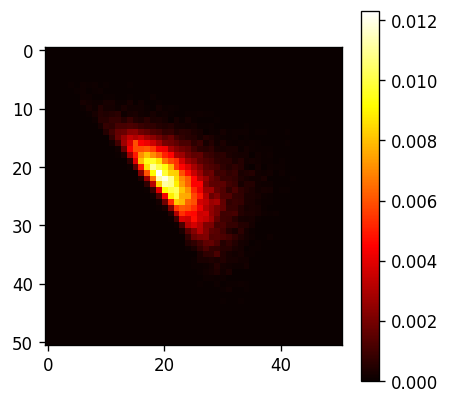

In [175]:
plt.figure(figsize=(4, 4))
plt.imshow(pyy[12, :, :, 3], cmap="hot")
plt.colorbar()
plt.show()